# 01_preprocess_metadata.ipynb

Предобработка и анализ файла `metadata.csv` из датасета COVID-19 Chest X-Ray Dataset.

В этом ноутбуке мы:
- загружаем исходный файл `metadata.csv`;
- исследуем качество данных (пропуски, дубликаты, распределения);
- очищаем данные (удаляем дубликаты, унифицируем диагнозы);
- заполняем пропуски в возрасте;
- создаём дополнительные признаки (возрастные группы);
- сохраняем очищенные данные в CSV и Parquet, чтобы потом загрузить их в HDFS.


In [25]:
# Импорт основных библиотек для работы с табличными данными и графиками
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
# Настройки внешнего вида графиков и отображения таблиц
sns.set(style="whitegrid")              # Устанавливаем стиль графиков "белый фон + сетка"
plt.rcParams["figure.figsize"] = (8, 5) # Размер графиков по умолчанию: ширина 8, высота 5 (в дюймах)
pd.set_option("display.max_columns", 50) # Разрешаем pandas показывать до 50 колонок при выводе таблицы


In [27]:
# Пути к файлам данных (относительно папки notebooks/)
RAW_METADATA_PATH = "metadata.csv"              # Путь к исходному metadata.csv
CLEAN_METADATA_CSV_PATH = "metadata_cleaned.csv"   # Куда сохранить очищенный CSV
CLEAN_METADATA_PARQUET_PATH = "metadata.parquet"   # Куда сохранить Parquet-версию


In [28]:
# Загрузка исходного файла metadata.csv в DataFrame pandas
metadata = pd.read_csv(RAW_METADATA_PATH)
metadata.head()


,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [29]:
# Общая информация о таблице: размеры, типы данных, количество непустых значений
metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               950 non-null    object 
 1   offset                  697 non-null    float64
 2   sex                     870 non-null    object 
 3   age                     713 non-null    float64
 4   finding                 950 non-null    object 
 5   RT_PCR_positive         593 non-null    object 
 6   survival                361 non-null    object 
 7   intubated               248 non-null    object 
 8   intubation_present      250 non-null    object 
 9   went_icu                397 non-null    object 
 10  in_icu                  335 non-null    object 
 11  needed_supplemental_O2  90 non-null     object 
 12  extubated               37 non-null     object 
 13  temperature             78 non-null     float64
 14  pO2_saturation          119 non-null    fl

In [30]:
# Описательная статистика для числовых колонок (например, возраст)
metadata.describe()


,offset,age,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count
count,697.000000,713.000000,78.000000,119.000000,16.000000,28.000000,40.000000
mean,9.083214,53.534362,38.898718,78.475630,5.024375,5.307143,4.638050
std,31.664077,16.949007,6.494383,38.742573,2.660341,3.489956,20.550033
min,-360.000000,18.000000,36.000000,20.000000,0.220000,0.000000,0.400000
25%,1.000000,40.000000,37.800000,55.000000,3.067500,2.725000,0.746500
50%,5.000000,54.000000,38.150000,85.000000,4.745000,4.800000,1.100000
75%,10.000000,68.000000,38.975000,95.000000,6.857500,6.925000,1.600000
max,365.000000,94.000000,95.000000,340.000000,11.200000,12.900000,131.000000


In [31]:
# Смотрим, какие диагнозы встречаются в колонке 'finding'
metadata["finding"].value_counts(dropna=False).head(20)


finding
Pneumonia/Viral/COVID-19             584
todo                                  83
Pneumonia                             81
Pneumonia/Fungal/Pneumocystis         30
Pneumonia/Bacterial/Streptococcus     22
No Finding                            22
Tuberculosis                          18
Pneumonia/Viral/SARS                  16
Pneumonia/Lipoid                      13
Pneumonia/Bacterial/Mycoplasma        11
Pneumonia/Viral/MERS-CoV              10
Pneumonia/Bacterial/Klebsiella        10
Pneumonia/Bacterial/Legionella        10
Pneumonia/Bacterial/Nocardia           8
Pneumonia/Viral/Varicella              6
Pneumonia/Viral/Influenza              5
Pneumonia/Bacterial                    4
Pneumonia/Bacterial/E.Coli             4
Pneumonia/Viral/Herpes                 3
Pneumonia/Bacterial/Chlamydophila      3
Name: count, dtype: int64

In [32]:
# Смотрим распределение значений в колонке 'view' (тип проекции снимка)
metadata["view"].value_counts(dropna=False)


view
PA           344
AP Supine    234
AP           203
L             84
Axial         68
Coronal       16
AP Erect       1
Name: count, dtype: int64

In [33]:
# Проверим и удалим дубликаты строк
initial_rows = len(metadata)                      # Сохраняем исходное количество строк
metadata = metadata.drop_duplicates()             # Удаляем точные дубликаты по всем колонкам
after_drop_rows = len(metadata)                   # Смотрим, сколько строк осталось
print(f"Удалено дубликатов: {initial_rows - after_drop_rows}")


Удалено дубликатов: 0


In [34]:
# Функция для унификации исходных диагнозов в несколько основных категорий
def unify_finding(raw_finding: str) -> str:
    """
    Преобразовать исходное значение диагноза в одну из укрупнённых категорий:
    'COVID19', 'PNEUMONIA', 'NORMAL', 'OTHER'.
    """
    if pd.isna(raw_finding):
        return "OTHER"  # Если диагноз не указан, относим к прочим случаям

    text = str(raw_finding).upper()  # Приводим к строке и к верхнему регистру для удобства поиска

    if "COVID" in text:
        return "COVID19"
    if "PNEUMONIA" in text or "PNEUMONITIS" in text:
        return "PNEUMONIA"
    if "NORMAL" in text or "NO FINDING" in text:
        return "NORMAL"

    # Все остальные варианты складываем в категорию OTHER
    return "OTHER"

# Применяем функцию ко всей колонке 'finding' и создаём новую колонку 'finding_unified'
metadata["finding_unified"] = metadata["finding"].apply(unify_finding)

# Проверяем распределение новых категорий
metadata["finding_unified"].value_counts()


finding_unified
COVID19      584
PNEUMONIA    242
OTHER        102
NORMAL        22
Name: count, dtype: int64

In [35]:
# Анализ пропусков в колонке 'age'
print("Всего строк:", len(metadata))
print("Непустых значений возраста:", metadata["age"].notna().sum())
print("Пропусков возраста:", metadata["age"].isna().sum())

# Смотрим распределение возрастов там, где возраст указан
metadata["age"].dropna().describe()


Всего строк: 950
Непустых значений возраста: 713
Пропусков возраста: 237


count    713.000000
mean      53.534362
std       16.949007
min       18.000000
25%       40.000000
50%       54.000000
75%       68.000000
max       94.000000
Name: age, dtype: float64

In [36]:
# Функция для заполнения пропусков в возрасте случайным значением в диапазоне 20-80
def impute_age(age_value):
    """
    Если возраст указан, возвращаем его как есть.
    Если возраст пропущен, генерируем случайное целое число от 20 до 80.
    """
    if pd.isna(age_value):
        return np.random.randint(20, 81)  # верхняя граница в randint не включается, поэтому 81
    return age_value

# Применяем функцию ко всей колонке 'age'
metadata["age_filled"] = metadata["age"].apply(impute_age)

# Проверяем, что в новой колонке пропусков нет
print("Пропусков в age_filled:", metadata["age_filled"].isna().sum())


Пропусков в age_filled: 0


In [37]:
# Функция для отнесения пациента к возрастной группе по заполненному возрасту
def age_to_group(age_value):
    """
    Преобразует числовой возраст в возрастную категорию:
    'child'  (младше 18),
    'adult'  (от 18 до 59),
    'senior' (60 и старше).
    """
    # На всякий случай приводим к числу (float или int)
    age = float(age_value)

    if age < 18:
        return "child"
    elif age < 60:
        return "adult"
    else:
        return "senior"

# Создаём новую колонку 'age_group' на основе колонки 'age_filled'
metadata["age_group"] = metadata["age_filled"].apply(age_to_group)

# Проверяем распределение возрастных групп
metadata["age_group"].value_counts()


age_group
adult     581
senior    369
Name: count, dtype: int64

In [38]:
# Выбираем только полезные для дальнейшего анализа колонки
columns_to_keep = [
    "patientid",          # идентификатор пациента
    "filename",           # имя файла изображения
    "age",                # исходный возраст (как есть)
    "age_filled",         # заполненный возраст
    "age_group",          # возрастная группа
    "sex",                # пол
    "view",               # проекция снимка
    "finding",            # исходный диагноз
    "finding_unified",    # укрупнённый диагноз
    "date"                # дата исследования (если есть)
]

metadata_clean = metadata[columns_to_keep].copy()
metadata_clean.head()


,patientid,filename,age,age_filled,age_group,sex,view,finding,finding_unified,date
0,2,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,65.0,65.0,senior,M,PA,Pneumonia/Viral/COVID-19,COVID19,"January 22, 2020"
1,2,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,65.0,65.0,senior,M,PA,Pneumonia/Viral/COVID-19,COVID19,"January 25, 2020"
2,2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,65.0,65.0,senior,M,PA,Pneumonia/Viral/COVID-19,COVID19,"January 27, 2020"
3,2,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,65.0,65.0,senior,M,PA,Pneumonia/Viral/COVID-19,COVID19,"January 28, 2020"
4,4,nejmc2001573_f1a.jpeg,52.0,52.0,adult,F,PA,Pneumonia/Viral/COVID-19,COVID19,"January 25, 2020"


In [39]:
# Сохраняем очищенные данные в CSV и Parquet для дальнейшей загрузки в HDFS/Spark

# CSV-версия (удобно смотреть глазами или открывать в Excel)
metadata_clean.to_csv(CLEAN_METADATA_CSV_PATH, index=False)

# Parquet-версия (оптимальный формат для Spark)
metadata_clean.to_parquet(CLEAN_METADATA_PARQUET_PATH, index=False)

print("Файлы сохранены:")
print("CSV   ->", CLEAN_METADATA_CSV_PATH)
print("Parquet ->", CLEAN_METADATA_PARQUET_PATH)


Файлы сохранены:
CSV   -> metadata_cleaned.csv
Parquet -> metadata.parquet


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


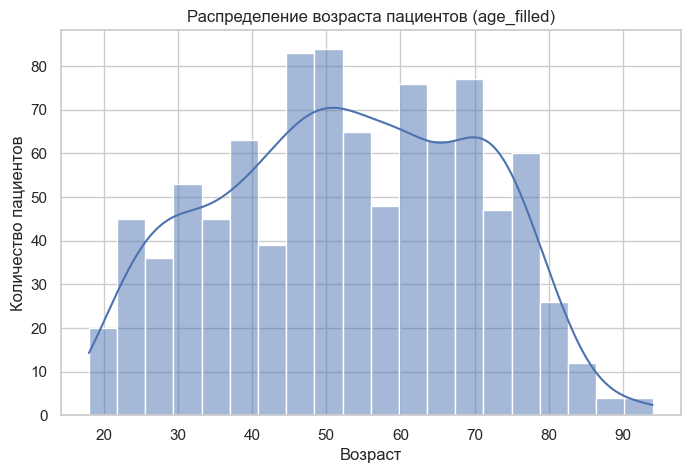

In [40]:
# Гистограмма распределения заполненного возраста
sns.histplot(data=metadata_clean, x="age_filled", bins=20, kde=True)
plt.title("Распределение возраста пациентов (age_filled)")
plt.xlabel("Возраст")
plt.ylabel("Количество пациентов")
plt.show()


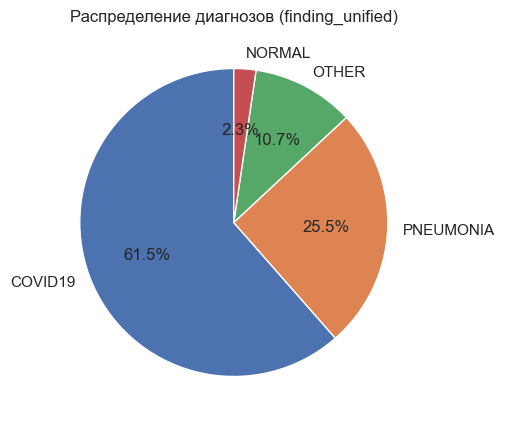

In [41]:
# Круговая диаграмма распределения укрупнённых диагнозов
diagnosis_counts = metadata_clean["finding_unified"].value_counts()

diagnosis_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Распределение диагнозов (finding_unified)")
plt.ylabel("")  # убираем подпись оси Y для красоты
plt.show()
